In [2]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/Users/kai/Downloads/graduation/AMFtrack")
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from amftrack.util.sys import get_current_folders, update_plate_info, test_path

In [4]:
from amftrack.util.sys import storage_path
from amftrack.util.geometry import generate_index_along_sequence
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    compute_edge_width_profile,
    extract_section_profiles_for_edge,
)

In [5]:
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    Node,
    Edge,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
)

In [6]:
directory = storage_path+"/"
plate_name = "20221116_0311_Plate21"
directory

'/Users/kai/Downloads/graduation/code/datasets/'

In [7]:
# This function will make a json file in tmp folder to record the plate information.
update_plate_info(directory)

analysed:   0%|          | 0/43 [00:00<?, ?it/s]

In [8]:
# this function can make a df of the plate in current folder.
# it can get several plate folders at once.
# Notice: it is for folder not for file!
folder_df = get_current_folders(directory)
folder_df

total_path Plate PrincePos  \
0  /Users/kai/Downloads/graduation/code/datasets/...   705        21   
1  /Users/kai/Downloads/graduation/code/datasets/...  1045         2   
2  /Users/kai/Downloads/graduation/code/datasets/...   452        32   

       root strain          medium split Pbait CrossDate Temperature  ...  \
0  'Carrot'   'C2'  '001P100N100C'   'Y'   '-'  20221014          25  ...   
1  'Carrot'   'C2'  '001P100N200C'   'Y'   '-'  20220504          25  ...   
2  'Carrot'   'C2'  '001P100N100C'   'Y'   '-'  20221017          25  ...   

  /Analysis/transform.mat /Analysis/transform_corrupt.mat  \
0                    True                           False   
1                    True                           False   
2                    True                           False   

  /Analysis/skeleton_realigned_compressed.mat /Analysis/nx_graph_pruned.p  \
0                                        True                        True   
1                                        True                        True   
2                                        True                        True   

  /Analysis/nx_graph_pruned_width.p /Analysis/nx_graph_pruned_labeled.p  \
0                              True                                True   
1                              True                                True   
2                              True                                True   

                 date                 folder      unique_id  \
0  16.11.2022, 03:11:  20221116_0311_Plate21   705_20221014   
1  08.05.2022, 09:47:  20220508_0947_Plate02  1045_20220504   
2  26.10.2022, 10:13:  20221026_1013_Plate32   452_20221017   

             datetime  
0 2022-11-16 03:11:00  
1 2022-05-08 09:47:00  
2 2022-10-26 10:13:00  

[3 rows x 24 columns]

In [9]:
list(folder_df.total_path)

['/Users/kai/Downloads/graduation/code/datasets/20221116_0311_Plate21',
 '/Users/kai/Downloads/graduation/code/datasets/20220508_0947_Plate02',
 '/Users/kai/Downloads/graduation/code/datasets/20221026_1013_Plate32']

In [10]:
selected_df = folder_df.loc[folder_df["folder"] == plate_name]
selected_df 

total_path Plate PrincePos  \
0  /Users/kai/Downloads/graduation/code/datasets/...   705        21   

       root strain          medium split Pbait CrossDate Temperature  ...  \
0  'Carrot'   'C2'  '001P100N100C'   'Y'   '-'  20221014          25  ...   

  /Analysis/transform.mat /Analysis/transform_corrupt.mat  \
0                    True                           False   

  /Analysis/skeleton_realigned_compressed.mat /Analysis/nx_graph_pruned.p  \
0                                        True                        True   

  /Analysis/nx_graph_pruned_width.p /Analysis/nx_graph_pruned_labeled.p  \
0                              True                                True   

                 date                 folder     unique_id            datetime  
0  16.11.2022, 03:11:  20221116_0311_Plate21  705_20221014 2022-11-16 03:11:00  

[1 rows x 24 columns]

In [11]:
exp = Experiment(directory)
exp.load(selected_df, suffix="")
exp.load_tile_information(0)

2022-11-16 03:11:00


## Load Model

In [12]:
sys.path.append("/Users/kai/Downloads/graduation/code")
from models.model import *
from models.data_prepare import *
model_save_path = os.path.join(os.path.split(storage_path)[0],"models")
model_BO_84 = load_model(model_save_path, select_model="BO_CNN_MAE_0.84_vary_lum_focus")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 1)            0         
                                                                 
 conv_1 (Conv1D)             (None, 91, 64)            704       
                                                                 
 conv_2 (Conv1D)             (None, 72, 224)           286944    
                                                                 
 conv_3 (Conv1D)             (None, 58, 32)            107552    
                                                                 
 conv_4 (Conv1D)             (None, 39, 224)           143584    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 224)          0         
 )                                                               
                                                        

## Set extraction parameters

In [13]:
width_fun = lambda edge: compute_edge_width_profile(
    exp, 0, edge, resolution=4, offset=5)
f = lambda n: generate_index_along_sequence(n, resolution=4, offset=5)
f_profiles = lambda edge: extract_section_profiles_for_edge(
    exp, 0, edge, resolution=5, offset=4, step=3)

## Full Visualization

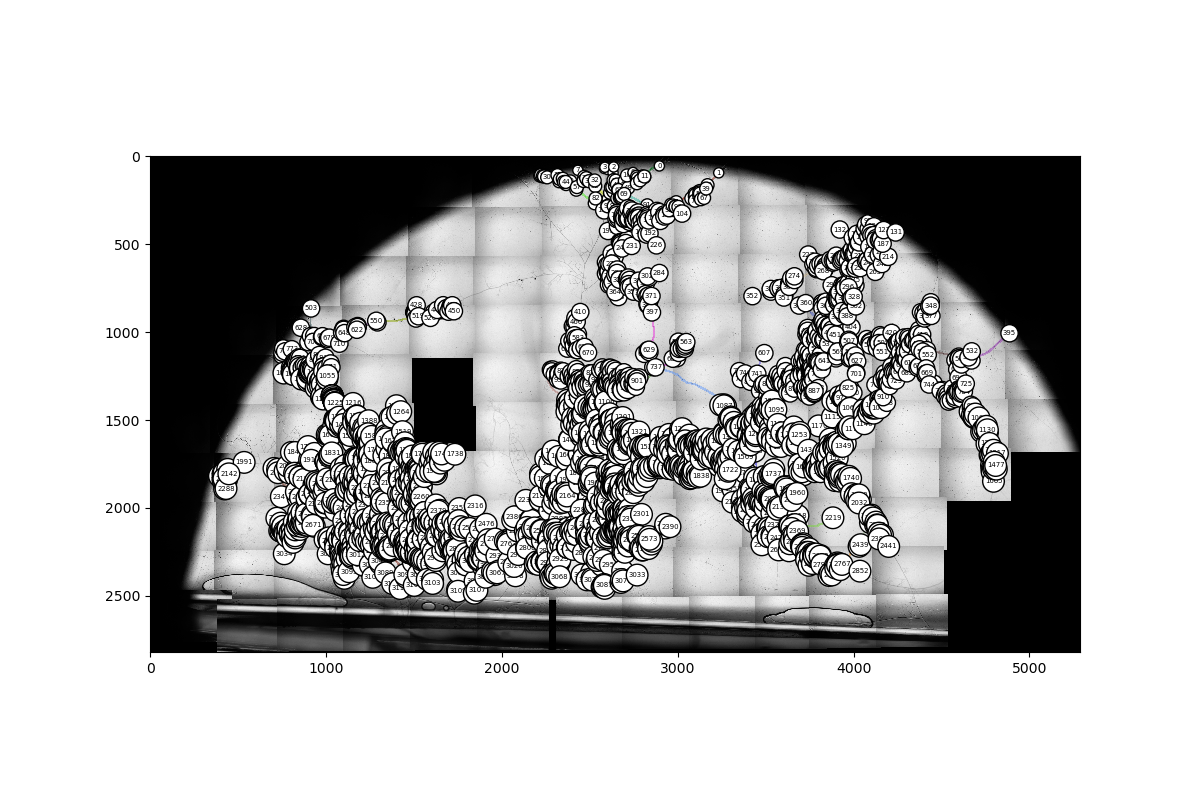

In [14]:
%matplotlib widget
plot_full_image_with_features(
    exp,
    0,
    downsizing=10,
    dilation=10,
    edges=get_all_edges(exp, 0),
    nodes=get_all_nodes(exp, 0),
)
# If this cannot zoom in and zoom out, make sure you already activate the conda environment(project).
# downsizing for reducing the image resolution
# When check the x,y position, downsizing should be one
# dilation: only for edges: thickness of the edges (dilation applied to the pixel list)

In [51]:
appex_edge_1 = [2589, 2566]  
# appex_edge_2 = [3101,3090]
# medium_edge_1 = [3055, 3089]
# big_edge_1 = [3105, 2946]
# edges_nodes = [appex_edge_1, appex_edge_2, medium_edge_1, big_edge_1]
edges_nodes=[appex_edge_1]

In [52]:
edges = []
for edge in edges_nodes:
    edges.append(get_edge_from_node_labels(exp, 0, edge[0], edge[1]))
edges

[Edge(2566,2589)]

## Plot the edges that were chosen on the original image

In [53]:
start_nodes = [edge.begin for edge in edges]
start_nodes

[Node(2566)]

In [54]:
end_nodes = [edge.end for edge in edges]
end_nodes

[Node(2589)]

In [55]:
nodes = [node for l in [start_nodes, end_nodes] for node in l ]
nodes

[Node(2566), Node(2589)]

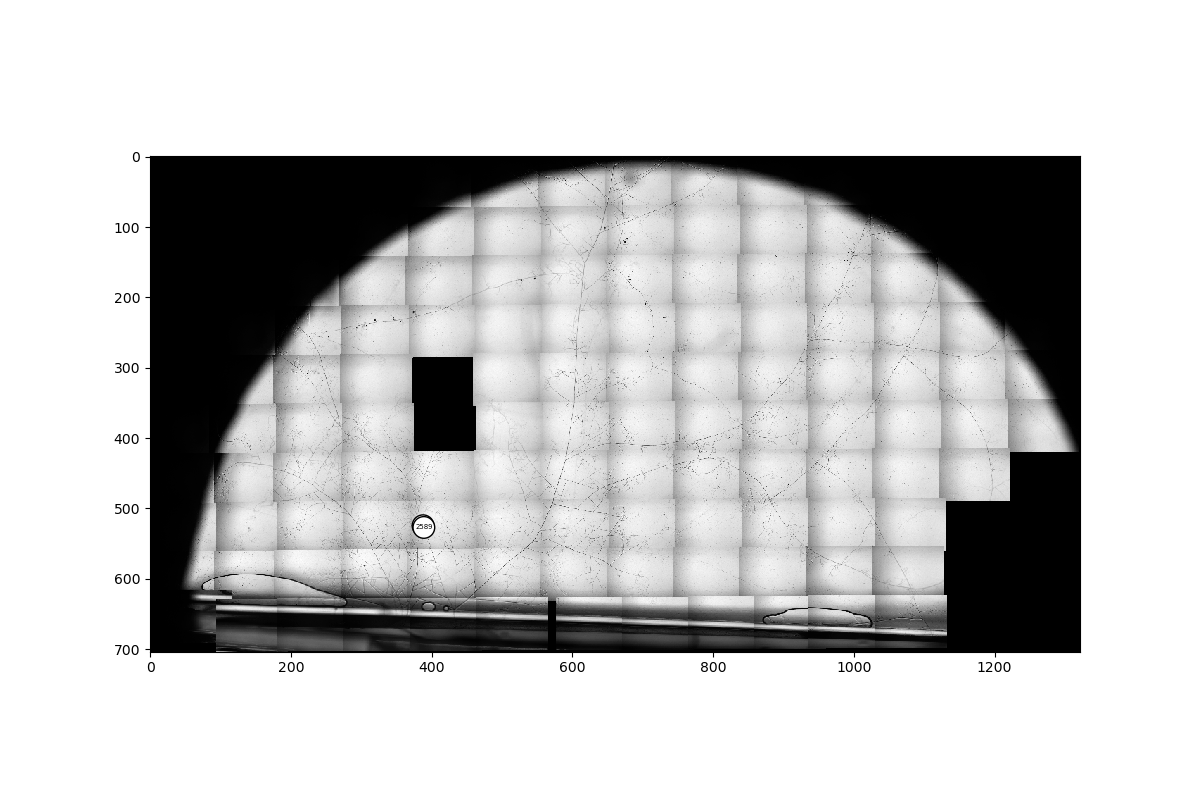

In [56]:
%matplotlib widget
plot_full_image_with_features(
    exp, 0, downsizing=40, dilation=1, edges=edges, nodes=nodes
)

## Visualize the slices that were extracted

In [75]:
edge = edges[0]

In [76]:
f = lambda n: generate_index_along_sequence(n, resolution=4, offset=5)
f_profiles = lambda edge: extract_section_profiles_for_edge(
    exp, 0, edge, resolution=5, offset=4, step=3)

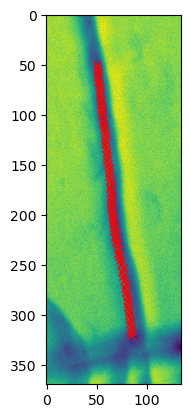

In [77]:
plot_edge_cropped(edge, 0, mode=3, f=f)

In [78]:
slices, coords1, coords2 = f_profiles(edge)
slices.shape

(57, 120)

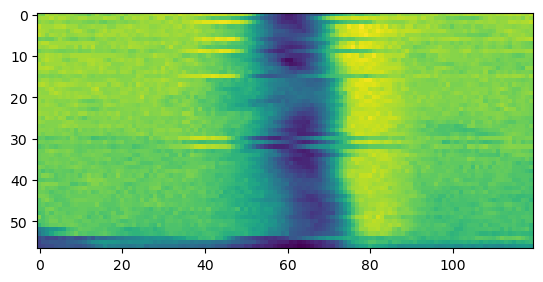

In [79]:
plt.imshow(slices)

In [92]:
edge = edges[0]
width_fun = lambda edge: compute_edge_width_profile(
    exp, 0, edge, resolution=4, offset=5,target_length = 100)
widths = np.squeeze(width_fun(edge))

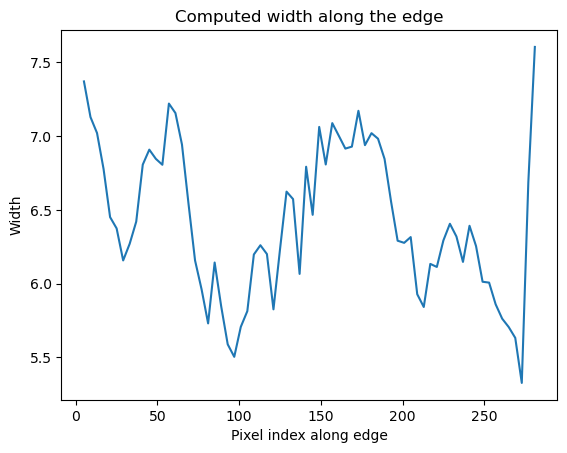

In [93]:
plt.plot(f(len(edge.pixel_list(0))), list(widths))
plt.xlabel("Pixel index along edge")
plt.ylabel("Width")
plt.title("Computed width along the edge")
plt.show()

## Edge 2

In [94]:
edge = edges[1]
width_fun = lambda edge: compute_edge_width_profile(
    exp, 0, edge, resolution=4, offset=5,target_length = 100)
widths = np.squeeze(width_fun(edge))

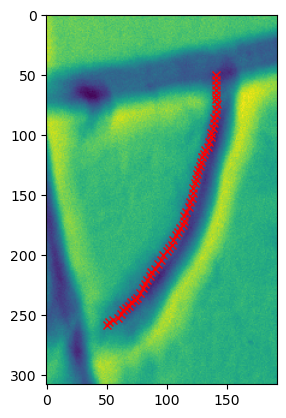

In [95]:
plot_edge_cropped(edge, 0, mode=3, f=f)

In [96]:
slices, coords1, coords2 = f_profiles(edge)
slices.shape

(50, 120)

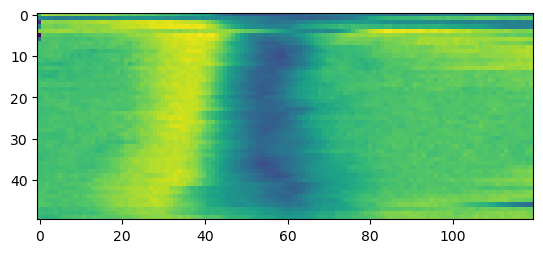

In [97]:
plt.imshow(slices)

Text(0.5, 1.0, 'Computed width along the edge')

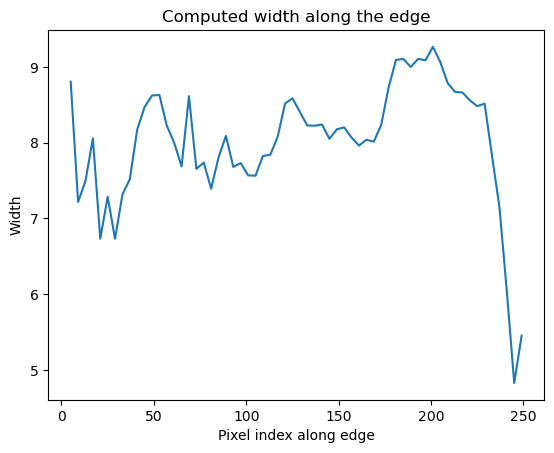

In [100]:
plt.plot(f(len(edge.pixel_list(0))), list(widths))
plt.xlabel("Pixel index along edge")
plt.ylabel("Width")
plt.title("Computed width along the edge")

## Edge3

In [110]:
edge = edges[2]
width_fun = lambda edge: compute_edge_width_profile(
    exp, 0, edge, resolution=4, offset=5,target_length = 100)
widths = np.squeeze(width_fun(edge))
len(widths)

156

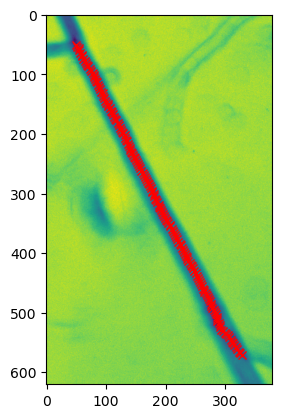

In [112]:
plot_edge_cropped(edge, 0, mode=3, f=f)

Text(0.5, 1.0, 'Computed width along the edge')

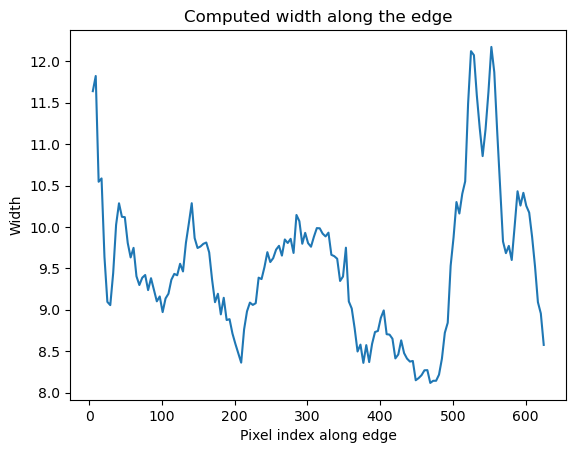

In [113]:
plt.plot(f(len(edge.pixel_list(0))), list(widths))
plt.xlabel("Pixel index along edge")
plt.ylabel("Width")
plt.title("Computed width along the edge")

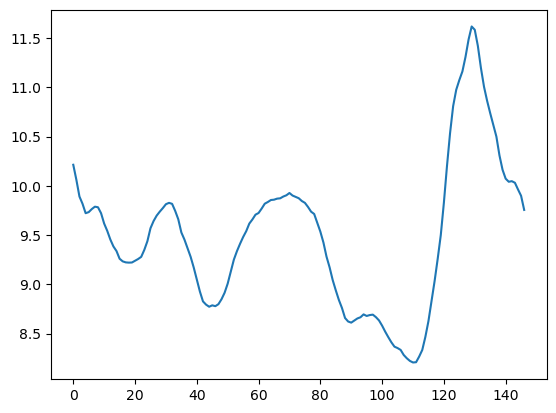

In [115]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w
plt.plot(moving_average(widths, 10))

In [118]:
means = []
medians = []
lengths = []
std = []
for edge in edges:
    widths = width_fun(edge)
    means.append(np.mean(widths))
    medians.append(np.median(widths))
    lengths.append(len(widths))
    std.append(np.std(widths))

The mean of the edges are 6.421289443969727
The median of the edges are [6.346587, 8.083351, 9.519487, 7.326936]
The lengths of the edges are [70, 62, 156, 632]
The std of the edges are [0.5060772, 0.82639444, 0.8832198, 1.1685998]


In [137]:
print(f"The mean of the edges are {means}")
print(f"The median of the edges are {medians}")
print(f"The lengths of the edges are {lengths}")
print(f"The std of the edges are {std}")

The mean of the edges are [6.4212894, 8.0141, 9.527385, 7.101986]
The median of the edges are [6.346587, 8.083351, 9.519487, 7.326936]
The lengths of the edges are [70, 62, 156, 632]
The std of the edges are [0.5060772, 0.82639444, 0.8832198, 1.1685998]


In [138]:
edges = get_all_edges(exp, 0)
medians = {}
for edge in edges:
    if len(edge.pixel_list(0)) > 100:
        widths = width_fun(edge)
        medians[edge] = np.median(widths)

(array([1031.,  949.,  476.,  168.,   43.,   14.]),
 array([ 2.20457745,  4.54534149,  6.88610601,  9.22686958, 11.56763458,
        13.90839863, 16.24916267]),
 <BarContainer object of 6 artists>)

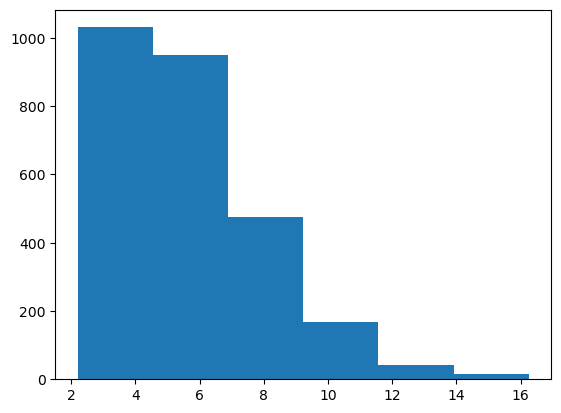

In [147]:
plt.hist(medians.values(), bins=6)

## For full plate

In [148]:
print(f"The minimum value of the full plate is {np.min(list(medians.values()))}")
print(f"The maximum value of the full plate is {np.max(list(medians.values()))}")

The minimum value of the full plate is 2.2045774459838867
The maximum value of the full plate is 16.249162673950195


In [149]:
bins = [[0.5, 2.5], [2.5, 4], [4, 6], [6, 12]]

In [150]:
def f_w(edge):
    if edge in medians:
        return medians[edge]
    else:
        return 0.0

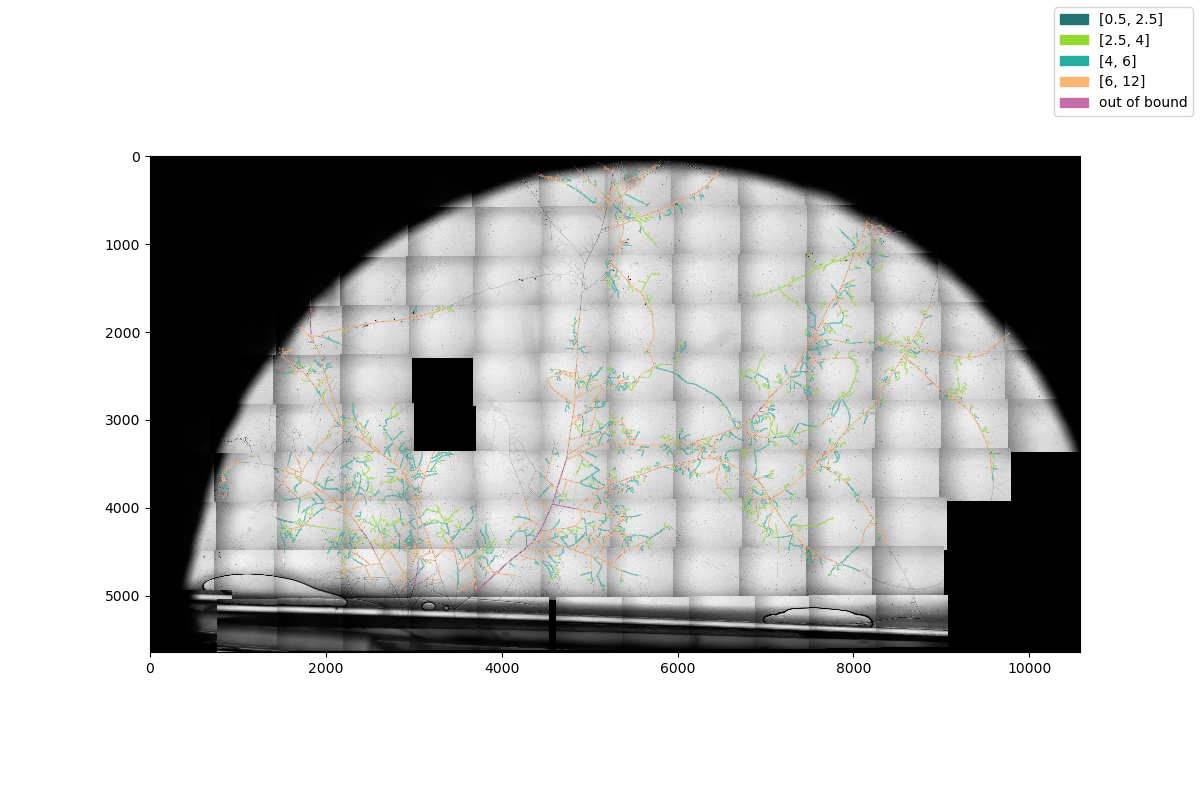

In [152]:
%matplotlib widget
plot_edge_width(exp, 0, width_fun=f_w, intervals=bins, dilation=15, color_seed=100)